## Multinomial NB Implementation on scaled reduced dataset with LDA

In [3]:
# Utilities
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt

# Models
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [1]:
seed = 23

In [5]:
df_scaled = pd.read_csv('../../Data/dataset_preprocessed.csv')

In [6]:
columns = df_scaled.columns

In [9]:
df_train_lda = pd.read_csv('../../DimensionalityReductionData/X_train_LDA.csv', names=columns)
df_test_lda = pd.read_csv('../../DimensionalityReductionData/X_test_LDA.csv', names=columns)

In [11]:
labels = df_scaled['averageRating']
_, _, y_train, y_test = train_test_split(df_scaled.drop(columns=['averageRating']), labels, test_size=0.2, random_state=42)

df_train_lda['averageRating'] = y_train.reset_index(drop=True)
df_test_lda['averageRating'] = y_test.reset_index(drop=True)

In [12]:
df_scaled.head()

,releaseYear,runtimeMinutes,lifetimeGross,nrOfReleases,director_nrOfMovies,nrOfEmployees,nrOfActors,averageRating,numVotes,sameYearTotalMoviesReleased,...,Music,Musical,Mystery,Other,Romance,Sci-Fi,Sport,Thriller,War,Western
0,0.798077,0.186170,0.000039,0.205128,0.022495,0.410256,0.384615,1,0.003324,0.248557,...,0,0,0,0,0,0,0,0,0,0
1,0.932692,0.186170,0.000017,0.102564,0.006135,0.538462,0.384615,0,0.000051,0.912407,...,0,0,0,0,1,0,0,0,0,0
2,0.826923,0.425532,0.002121,0.525641,0.092025,0.538462,0.423077,1,0.034478,0.347696,...,0,0,0,0,0,0,0,0,0,0
3,0.894231,0.276596,0.000094,0.410256,0.085890,0.487179,0.384615,0,0.024388,0.719691,...,0,0,0,0,0,0,0,0,0,0
4,0.903846,0.239362,0.000094,0.038462,0.006135,0.282051,0.153846,0,0.000032,0.754540,...,0,0,0,0,0,0,0,0,0,0


In [14]:
def calculate_metrics(model_name, y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Weighted F1': f1_score(y_true, y_pred, average='weighted'),
        'Weighted Precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'Weighted Recall': recall_score(y_true, y_pred, average='weighted'),
        'Macro-Averaged Precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Macro-Averaged Recall': recall_score(y_true, y_pred, average='macro'),
        'F1': str(f1_score(y_true, y_pred, average=None)),
        'Precision': str( precision_score(y_true, y_pred, average=None, zero_division=0)),
    }

    # Print the metrics
    print(f"Metrics for {model_name}:")
    for metric_name, metric_value in metrics.items():
        try:
            print(f"{metric_name}: {metric_value:.4f}")
        except:
            print(f"{metric_name}: {metric_value}")

    # Print the classification report
    print("classification report")
    report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'], zero_division=0)
    print(report)

    print("Confusion Matrix")
    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmd.plot()

    plt.title(f'Confusion matrix for model {model_name} (Accuracy:{metrics["Accuracy"]:.4f})')
    plt.show()

    # Create df to store metrics
    df_metrics = pd.DataFrame(metrics, index=[model_name])

    return df_metrics

In [22]:
df_train_lda = df_train_lda.clip(lower=0)
df_test_lda = df_test_lda.clip(lower=0)

df_train_lda.fillna(0.0, inplace=True)
df_test_lda.fillna(0.0, inplace=True)

model = MultinomialNB()
model.fit(df_train_lda[1:], y_train)

predictions = model.predict(df_test_lda)
print("Accuracy:", accuracy_score(y_test, predictions))

print("F1 score:", f1_score(y_test, predictions, average=None))

Accuracy: 0.44403730846102596
F1 score: [0.52355124 0.33266693]


In [24]:
param_grid = {
    'alpha' : [0.5, 0.75, 1.0],
    'fit_prior' : [True, False]
}

model = MultinomialNB()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(df_train_lda[1:], y_train)

print("The parameters with the highest score: ", grid_search.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
The parameters with the highest score:  {'alpha': 1.0, 'fit_prior': False}


In [25]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)

# Show top 10 parameters for this model
minimalistic_results = cv_results_df[['params', 'mean_test_score']]
sorted_results = minimalistic_results.sort_values(by='mean_test_score', ascending=False)

print(sorted_results.head(10))

                                params  mean_test_score
5   {'alpha': 1.0, 'fit_prior': False}         0.623714
1   {'alpha': 0.5, 'fit_prior': False}         0.623547
3  {'alpha': 0.75, 'fit_prior': False}         0.623547
4    {'alpha': 1.0, 'fit_prior': True}         0.623381
2   {'alpha': 0.75, 'fit_prior': True}         0.623131
0    {'alpha': 0.5, 'fit_prior': True}         0.623047


Metrics for MNB-LDA-GS-CV1:
Accuracy: 0.4427
Weighted F1: 0.4291
Weighted Precision: 0.4363
Weighted Recall: 0.4427
Macro-Averaged Precision: 0.4362
Macro-Averaged Recall: 0.4423
F1: [0.51772845 0.34003945]
Precision: [0.45723014 0.41522158]
classification report
              precision    recall  f1-score   support

     Class 0       0.46      0.60      0.52      1505
     Class 1       0.42      0.29      0.34      1497

    accuracy                           0.44      3002
   macro avg       0.44      0.44      0.43      3002
weighted avg       0.44      0.44      0.43      3002

Confusion Matrix


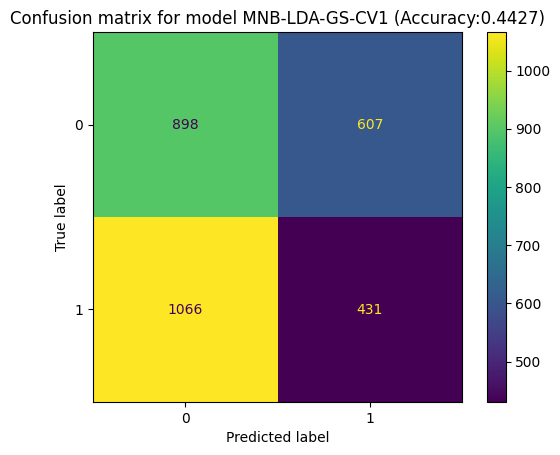

In [27]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(df_test_lda)
_ = calculate_metrics('MNB-LDA-GS-CV1', y_test, predictions)

In [29]:
# Predicting using other alternatives of fine-tuning from top 10 performances
other_alternatives = []
# Choose a set of parameters from sorted_results
for i in range(5):

  params = sorted_results.iloc[i]['params']
  print("Parameters from place: ", i, " ", params)

  model = MultinomialNB(**params)
  model.fit(df_train_lda[1:], y_train)

  predictions = model.predict(df_test_lda)

  chosen_accuracy = accuracy_score(y_test, predictions)
  print("Accuracy for chosen parameters:", chosen_accuracy)
  other_alternatives.append((chosen_accuracy,params))


Parameters from place:  0   {'alpha': 1.0, 'fit_prior': False}
Accuracy for chosen parameters: 0.44270486342438375
Parameters from place:  1   {'alpha': 0.5, 'fit_prior': False}
Accuracy for chosen parameters: 0.4423717521652232
Parameters from place:  2   {'alpha': 0.75, 'fit_prior': False}
Accuracy for chosen parameters: 0.44270486342438375
Parameters from place:  3   {'alpha': 1.0, 'fit_prior': True}
Accuracy for chosen parameters: 0.44403730846102596
Parameters from place:  4   {'alpha': 0.75, 'fit_prior': True}
Accuracy for chosen parameters: 0.44337108594270486


In [30]:
# get best from top 10
best_tuple = max(other_alternatives, key=lambda x: x[0])

In [31]:
print("Best accuracy and parameters after running the algorithm using other alternatives of fine tuning from top 10 performances")
print(best_tuple[0])
print(best_tuple[1])

Best accuracy and parameters after running the algorithm using other alternatives of fine tuning from top 10 performances
0.44403730846102596
{'alpha': 1.0, 'fit_prior': True}


In [34]:
# Run on training sample

# Choose a set of parameters from sorted_results
for i in range(5):

  params = sorted_results.iloc[i]['params']
  print("Parameters from place: ", i, " ", params)

  model = MultinomialNB(**params)
  model.fit(df_train_lda[1:], y_train)

  predictions = model.predict(df_train_lda)

  chosen_accuracy = accuracy_score(y_train, predictions[1:])
  print("Accuracy for chosen parameters:", chosen_accuracy)

Parameters from place:  0   {'alpha': 1.0, 'fit_prior': False}
Accuracy for chosen parameters: 0.6242085971342886
Parameters from place:  1   {'alpha': 0.5, 'fit_prior': False}
Accuracy for chosen parameters: 0.6242919026991003
Parameters from place:  2   {'alpha': 0.75, 'fit_prior': False}
Accuracy for chosen parameters: 0.6242919026991003
Parameters from place:  3   {'alpha': 1.0, 'fit_prior': True}
Accuracy for chosen parameters: 0.6238753748750416
Parameters from place:  4   {'alpha': 0.75, 'fit_prior': True}
Accuracy for chosen parameters: 0.6238753748750416


In [35]:
best_accuracy = 0
best_report = None
best_predictions = None
y_best_predictions = None
all_reports = []

for i in range(100):
  random_state_fit = np.random.randint(1000)

  test_size = 0.2
  X_train, X_test, y_train, y_test = train_test_split(
    df_scaled_sample.drop('averageRating', axis=1),
    df_scaled_sample['averageRating'], test_size=test_size,
    random_state=random_state_fit)


  model = MultinomialNB(**best_tuple[1])
  model.fit(X_train, y_train)

  predictions = model.predict(X_test)
  current_accuracy = accuracy_score(y_test, predictions)

  report = classification_report(y_test, predictions, output_dict=True, zero_division=0)
  all_reports.append(report)
  print(current_accuracy)

  if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        best_report = report
        best_predictions = predictions
        y_best_predictions = y_test

def average_classification_report(reports):
    metrics = ['precision', 'recall', 'f1-score']
    avg_report = {}
    for metric in metrics:
        avg_report[metric] = sum(r['macro avg'][metric] for r in reports) / len(reports)
    avg_report['accuracy'] = sum(r['accuracy'] for r in reports) / len(reports)
    return avg_report

avg_report = average_classification_report(all_reports)

print("Best Classification Report:")
print(classification_report(y_best_predictions, best_predictions, zero_division=0))
print("Best Accuracy:", best_accuracy)
print()
print("Average Classification Report:")
for metric, score in avg_report.items():
    print(f"{metric}: {score:.4f}")

0.6492338441039307
0.6808794137241839
0.6628914057295137
0.6735509660226515
0.6718854097268487
0.6838774150566289
0.6505662891405729
0.6772151898734177
0.6692205196535643
0.6808794137241839
0.6842105263157895
0.6745502998001333
0.667888074616922
0.6695536309127248
0.6812125249833444
0.6598934043970687
0.667221852098601
0.6735509660226515
0.6845436375749501
0.6782145236508994
0.6708860759493671
0.6722185209860093
0.6688874083944037
0.6708860759493671
0.6862091938707529
0.679213857428381
0.6578947368421053
0.6652231845436376
0.6832111925383078
0.6778814123917388
0.6638907395069953
0.6708860759493671
0.6585609593604264
0.6755496335776149
0.670219853431046
0.673217854763491
0.6725516322451699
0.6632245169886742
0.6735509660226515
0.670219853431046
0.6652231845436376
0.6662225183211192
0.6735509660226515
0.6665556295802798
0.6668887408394404
0.6685542971352432
0.6755496335776149
0.6858760826115923
0.667888074616922
0.6645569620253164
0.6812125249833444
0.6645569620253164
0.673217854763491
0

Metrics for MNB-LDA-Shuffled_best:
Accuracy: 0.6925
Weighted F1: 0.6886
Weighted Precision: 0.6964
Weighted Recall: 0.6925
Macro-Averaged Precision: 0.6974
Macro-Averaged Recall: 0.6876
F1: [0.72972182 0.6434917 ]
Precision: [0.67607162 0.71872304]
classification report
              precision    recall  f1-score   support

     Class 0       0.68      0.79      0.73      1572
     Class 1       0.72      0.58      0.64      1430

    accuracy                           0.69      3002
   macro avg       0.70      0.69      0.69      3002
weighted avg       0.70      0.69      0.69      3002

Confusion Matrix


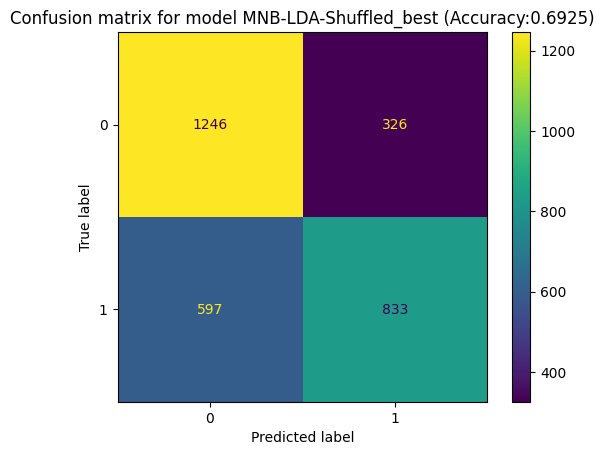

,Accuracy,Weighted F1,Weighted Precision,Weighted Recall,Macro-Averaged Precision,Macro-Averaged Recall,F1,Precision
MNB-LDA-Shuffled_best,0.692538,0.688646,0.696389,0.692538,0.697397,0.687569,[0.72972182 0.6434917 ],[0.67607162 0.71872304]


In [36]:
calculate_metrics('MNB-LDA-Shuffled_best', y_best_predictions, best_predictions)